In [1]:
%matplotlib inline
from pylab import *
from ipywidgets import interact, widgets
from IPython import display
from keyframes import hello
from keyframes import wipe_forehead
from keyframes import leftBackToStand
from collections import deque
keyframesDict = {"Hello!" : hello(), "Wipe It!" : wipe_forehead(), "Stand Up!" : leftBackToStand()}

In [2]:
from standing_up import StandingUpAgent
from recognize_posture import PostureRecognitionAgent
agent = PostureRecognitionAgent() #so he wont constantly try to get up when he is down

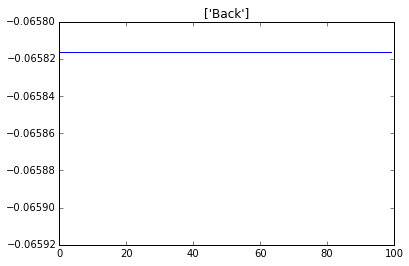

In [3]:
#setup Buttons:
buttons = []
def keyFrameOnClick(ev = None):
    global agent
    agent.set_keyframes(keyframesDict[ev.description])
    display.clear_output(True)
for label in keyframesDict:
    buttons.append(widgets.Button(description = label))
    buttons[-1].on_click(keyFrameOnClick)
display.display(widgets.HBox(buttons))

#setup interactive rest
joint_name='HeadYaw'
@interact(name=agent.joint_names)
def set_test_joint(name):
    global agent
    global joint_name
    joint_name = name
    agent.testJoint = joint_name
bezier = 0
@interact(setBezier=(0,1))
def set_bezier(setBezier):
    global bezier
    bezier = setBezier
@interact(kp=(0, 100, 1), ki=(-1, 1, 0.1), kd=(-1, 1, 0.1), delay=(0, 5))
def set_pid_parameters(kp, ki, kd, delay=1):
    global agent
    agent.joint_controller.Kp = kp
    agent.joint_controller.Ki = ki
    agent.joint_controller.Kd = kd
    agent.joint_controller.set_delay(delay)


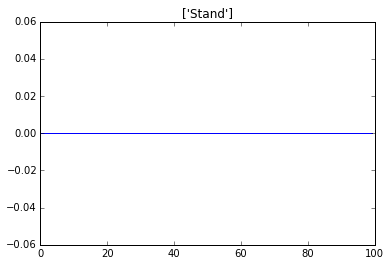

In [4]:
# inject plotting input agent's loop
cycle = 0
sensor = deque(maxlen=100)
target = deque(maxlen=100)
otherInterpolation = deque(maxlen=100)
orig_sense_think_act = agent.sense_think_act
def sense_think_act():
    global cycle
    global bezier
    cycle += 1
    orig_sense_think_act()
    sensor.append(agent.perception.joint[joint_name])
    target.append(agent.target_joints[joint_name])
    if bezier:
        interpolated  = agent.angle_interpolation(agent.keyframes,agent.perception,0)
    else: 
        interpolated  = agent.angle_interpolation(agent.keyframes,agent.perception,1)

    if joint_name in interpolated:
        otherInterpolation.append(interpolated[joint_name])
        
    if cycle % 10 == 0:  # plot every 10 cycles
        cla()
        plot(target, '-r')
        plot(sensor, '-b')
        title(agent.posture)
        if joint_name in interpolated:
            plot(otherInterpolation, '-g')
        display.clear_output(wait=True)
        display.display(gcf())
agent.sense_think_act = sense_think_act
agent.start()